## FashionMNIST

## Setup

In [249]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from cifar10_models.resnet import resnet18 as resnet18_cifar10

In [250]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


In [251]:
train_np = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()

test_np = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

print(train_np.shape, train_labels.shape)
print(test_np.shape, test_labels.shape)
print(len(np.unique(train_labels)))

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
10


## Feature Extraction

In [252]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9, visualize=False)
        hog_features.append(features)
        
    return np.array(hog_features)

train_hog = extract_hog_features(train_np)
test_hog = extract_hog_features(test_np)

print(train_hog.shape)

# ~58s

(60000, 1296)


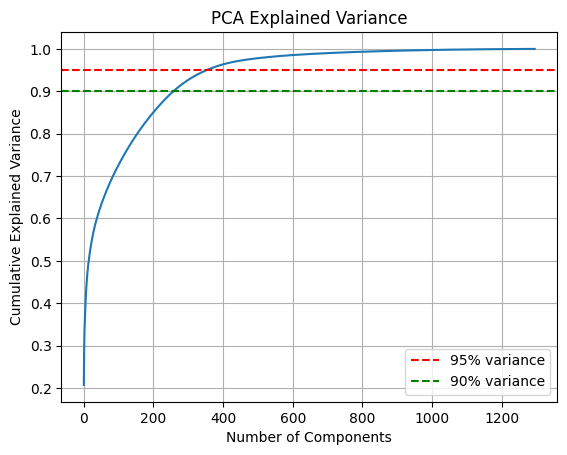

Number of components for 95% variance: 354
Number of components for 90% variance: 259


In [253]:
pca = PCA()
pca.fit(train_hog)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% variance')
plt.legend()
plt.grid()
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components for 95% variance: {n_components_95}")
print(f"Number of components for 90% variance: {n_components_90}")

# ~30s

In [254]:
n_components = n_components_95
pca = PCA(n_components=n_components)

train_pca = pca.fit_transform(train_hog)
test_pca = pca.transform(test_hog)

print(train_pca.shape, test_pca.shape)

# ~26s

(60000, 354) (10000, 354)


In [255]:
scaler = StandardScaler()
train_pca_scaled = scaler.fit_transform(train_pca)
test_pca_scaled = scaler.transform(test_pca)

print(f"Shape before selection: {train_pca_scaled.shape, test_pca_scaled.shape}")

Shape before selection: ((60000, 354), (10000, 354))


In [256]:
percentile = 18
selector_percentile = SelectPercentile(score_func=f_classif, percentile=percentile)
train_selected_percentile = selector_percentile.fit_transform(train_pca_scaled, train_labels)
test_selected_percentile = selector_percentile.transform(test_pca_scaled)

print(f"Shape after Select Percentile: {train_selected_percentile.shape, test_selected_percentile.shape}")

Shape after Select Percentile: ((60000, 64), (10000, 64))


In [257]:
def plot_accuracies_and_losses(train_losses, test_losses, train_accuracies, test_accuracies, title):

    max_train_accuracy = max(train_accuracies)
    max_test_accuracy = max(test_accuracies)
    max_train_epoch = train_accuracies.index(max_train_accuracy)
    max_test_epoch = test_accuracies.index(max_test_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='b')
    plt.plot(test_losses, label="Test Loss", color='r')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves ({title})")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy", color='b')
    plt.plot(test_accuracies, label="Test Accuracy", color='r')
    plt.scatter(max_train_epoch, max_train_accuracy, color='blue', label=f"Max Train Accuracy: {max_train_accuracy:.4f}", zorder=5)
    plt.scatter(max_test_epoch, max_test_accuracy, color='red', label=f"Max Test Accuracy: {max_test_accuracy:.4f}", zorder=5)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curves ({title})")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

## MLP over extracted features

In [258]:
X_train = torch.tensor(train_selected_percentile, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_test = torch.tensor(test_selected_percentile, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

In [259]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.model(x)
    
input_size = train_selected_percentile.shape[1]
num_classes = len(np.unique(train_labels))
model = MLP(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [260]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=True)
        for X_batch, y_batch in train_bar:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()

            train_bar.set_postfix(loss=loss.item())

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Testing", leave=True)
            for X_batch, y_batch in test_bar:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                test_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / len(test_loader.dataset))
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

num_epochs = 50
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

Epoch 1/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 977.77it/s]


Epoch 1/50, Train Loss: 1.6992, Test Loss: 1.6033, Train Acc: 0.7859, Test Acc: 0.8594


Epoch 2/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1015.61it/s]


Epoch 2/50, Train Loss: 1.6092, Test Loss: 1.5978, Train Acc: 0.8541, Test Acc: 0.8634


Epoch 3/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1042.52it/s]


Epoch 3/50, Train Loss: 1.6006, Test Loss: 1.5954, Train Acc: 0.8618, Test Acc: 0.8662


Epoch 4/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1022.21it/s]


Epoch 4/50, Train Loss: 1.5960, Test Loss: 1.5922, Train Acc: 0.8659, Test Acc: 0.8701


Epoch 5/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1183.61it/s]


Epoch 5/50, Train Loss: 1.5927, Test Loss: 1.5893, Train Acc: 0.8691, Test Acc: 0.8720


Epoch 6/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1206.59it/s]


Epoch 6/50, Train Loss: 1.5898, Test Loss: 1.5870, Train Acc: 0.8722, Test Acc: 0.8733


Epoch 7/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1063.64it/s]


Epoch 7/50, Train Loss: 1.5864, Test Loss: 1.5853, Train Acc: 0.8752, Test Acc: 0.8754


Epoch 8/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1239.55it/s]


Epoch 8/50, Train Loss: 1.5845, Test Loss: 1.5837, Train Acc: 0.8774, Test Acc: 0.8778


Epoch 9/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1300.99it/s]


Epoch 9/50, Train Loss: 1.5824, Test Loss: 1.5828, Train Acc: 0.8797, Test Acc: 0.8777


Epoch 10/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 603.05it/s]


Epoch 10/50, Train Loss: 1.5800, Test Loss: 1.5815, Train Acc: 0.8819, Test Acc: 0.8786


Epoch 11/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 671.28it/s]


Epoch 11/50, Train Loss: 1.5803, Test Loss: 1.5816, Train Acc: 0.8814, Test Acc: 0.8784


Epoch 12/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1124.43it/s]


Epoch 12/50, Train Loss: 1.5790, Test Loss: 1.5815, Train Acc: 0.8828, Test Acc: 0.8798


Epoch 13/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1108.61it/s]


Epoch 13/50, Train Loss: 1.5768, Test Loss: 1.5811, Train Acc: 0.8845, Test Acc: 0.8794


Epoch 14/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1221.48it/s]


Epoch 14/50, Train Loss: 1.5764, Test Loss: 1.5793, Train Acc: 0.8850, Test Acc: 0.8821


Epoch 15/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1144.69it/s]


Epoch 15/50, Train Loss: 1.5769, Test Loss: 1.5791, Train Acc: 0.8843, Test Acc: 0.8824


Epoch 16/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1100.85it/s]


Epoch 16/50, Train Loss: 1.5752, Test Loss: 1.5780, Train Acc: 0.8860, Test Acc: 0.8832


Epoch 17/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 811.32it/s]


Epoch 17/50, Train Loss: 1.5745, Test Loss: 1.5795, Train Acc: 0.8870, Test Acc: 0.8819


Epoch 18/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1312.86it/s]


Epoch 18/50, Train Loss: 1.5746, Test Loss: 1.5773, Train Acc: 0.8867, Test Acc: 0.8839


Epoch 19/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1174.78it/s]


Epoch 19/50, Train Loss: 1.5738, Test Loss: 1.5769, Train Acc: 0.8873, Test Acc: 0.8838


Epoch 20/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1269.52it/s]


Epoch 20/50, Train Loss: 1.5726, Test Loss: 1.5755, Train Acc: 0.8886, Test Acc: 0.8852


Epoch 21/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1259.35it/s]


Epoch 21/50, Train Loss: 1.5718, Test Loss: 1.5773, Train Acc: 0.8894, Test Acc: 0.8836


Epoch 22/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1070.87it/s]


Epoch 22/50, Train Loss: 1.5708, Test Loss: 1.5772, Train Acc: 0.8904, Test Acc: 0.8833


Epoch 23/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1249.36it/s]


Epoch 23/50, Train Loss: 1.5710, Test Loss: 1.5766, Train Acc: 0.8905, Test Acc: 0.8841


Epoch 24/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1259.36it/s]


Epoch 24/50, Train Loss: 1.5712, Test Loss: 1.5751, Train Acc: 0.8901, Test Acc: 0.8860


Epoch 25/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1108.59it/s]


Epoch 25/50, Train Loss: 1.5700, Test Loss: 1.5770, Train Acc: 0.8911, Test Acc: 0.8836


Epoch 26/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1239.52it/s]


Epoch 26/50, Train Loss: 1.5695, Test Loss: 1.5757, Train Acc: 0.8915, Test Acc: 0.8853


Epoch 27/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1210.10it/s]


Epoch 27/50, Train Loss: 1.5683, Test Loss: 1.5743, Train Acc: 0.8931, Test Acc: 0.8865


Epoch 28/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1239.52it/s]


Epoch 28/50, Train Loss: 1.5700, Test Loss: 1.5756, Train Acc: 0.8909, Test Acc: 0.8849


Epoch 29/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1132.52it/s]


Epoch 29/50, Train Loss: 1.5686, Test Loss: 1.5756, Train Acc: 0.8925, Test Acc: 0.8852


Epoch 30/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1239.55it/s]


Epoch 30/50, Train Loss: 1.5687, Test Loss: 1.5751, Train Acc: 0.8927, Test Acc: 0.8859


Epoch 31/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1192.56it/s]


Epoch 31/50, Train Loss: 1.5690, Test Loss: 1.5742, Train Acc: 0.8917, Test Acc: 0.8872


Epoch 32/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1175.29it/s]


Epoch 32/50, Train Loss: 1.5681, Test Loss: 1.5742, Train Acc: 0.8928, Test Acc: 0.8861


Epoch 33/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1380.87it/s]


Epoch 33/50, Train Loss: 1.5678, Test Loss: 1.5742, Train Acc: 0.8933, Test Acc: 0.8862


Epoch 34/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1049.46it/s]


Epoch 34/50, Train Loss: 1.5676, Test Loss: 1.5738, Train Acc: 0.8930, Test Acc: 0.8868


Epoch 35/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1157.51it/s]


Epoch 35/50, Train Loss: 1.5675, Test Loss: 1.5769, Train Acc: 0.8937, Test Acc: 0.8832


Epoch 36/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 996.33it/s]


Epoch 36/50, Train Loss: 1.5668, Test Loss: 1.5748, Train Acc: 0.8942, Test Acc: 0.8861


Epoch 37/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1290.33it/s]


Epoch 37/50, Train Loss: 1.5677, Test Loss: 1.5756, Train Acc: 0.8933, Test Acc: 0.8853


Epoch 38/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1229.85it/s]


Epoch 38/50, Train Loss: 1.5666, Test Loss: 1.5761, Train Acc: 0.8943, Test Acc: 0.8848


Epoch 39/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1166.07it/s]


Epoch 39/50, Train Loss: 1.5662, Test Loss: 1.5770, Train Acc: 0.8947, Test Acc: 0.8840


Epoch 40/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1201.68it/s]


Epoch 40/50, Train Loss: 1.5664, Test Loss: 1.5762, Train Acc: 0.8948, Test Acc: 0.8842


Epoch 41/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1210.94it/s]


Epoch 41/50, Train Loss: 1.5666, Test Loss: 1.5756, Train Acc: 0.8941, Test Acc: 0.8850


Epoch 42/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1249.10it/s]


Epoch 42/50, Train Loss: 1.5663, Test Loss: 1.5751, Train Acc: 0.8947, Test Acc: 0.8860


Epoch 43/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1085.66it/s]


Epoch 43/50, Train Loss: 1.5649, Test Loss: 1.5757, Train Acc: 0.8961, Test Acc: 0.8849


Epoch 44/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1192.58it/s]


Epoch 44/50, Train Loss: 1.5651, Test Loss: 1.5750, Train Acc: 0.8955, Test Acc: 0.8850


Epoch 45/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1104.65it/s]


Epoch 45/50, Train Loss: 1.5646, Test Loss: 1.5766, Train Acc: 0.8963, Test Acc: 0.8842


Epoch 46/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1269.51it/s]


Epoch 46/50, Train Loss: 1.5652, Test Loss: 1.5743, Train Acc: 0.8958, Test Acc: 0.8862


Epoch 47/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1070.88it/s]


Epoch 47/50, Train Loss: 1.5652, Test Loss: 1.5754, Train Acc: 0.8960, Test Acc: 0.8866


Epoch 48/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1093.20it/s]


Epoch 48/50, Train Loss: 1.5657, Test Loss: 1.5754, Train Acc: 0.8953, Test Acc: 0.8859


Epoch 49/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1174.78it/s]


Epoch 49/50, Train Loss: 1.5654, Test Loss: 1.5754, Train Acc: 0.8956, Test Acc: 0.8859


Epoch 50/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1174.78it/s]

Epoch 50/50, Train Loss: 1.5640, Test Loss: 1.5761, Train Acc: 0.8969, Test Acc: 0.8841


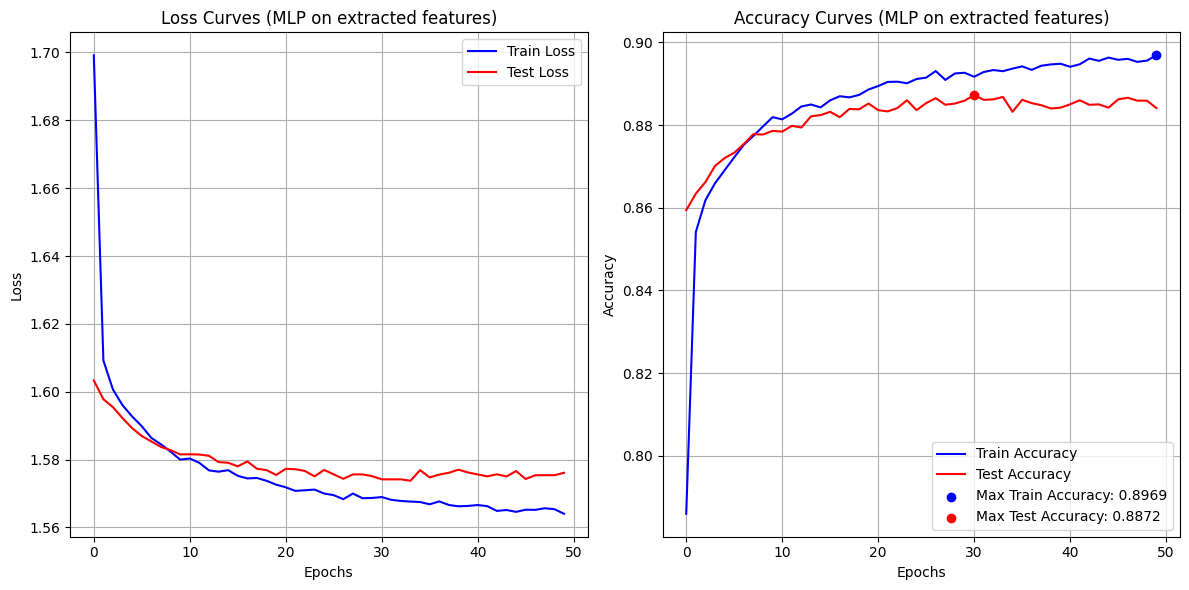

In [261]:
plot_accuracies_and_losses(train_losses, test_losses, train_accuracies, test_accuracies, "MLP on extracted features")

## MLP directly on images 

In [262]:
train_images_flattened = train_np.reshape(train_np.shape[0], -1).astype(np.float32)
test_images_flattened = test_np.reshape(test_np.shape[0], -1).astype(np.float32)

scaler = StandardScaler()
train_images_normalized = scaler.fit_transform(train_images_flattened)
test_images_normalized = scaler.transform(test_images_flattened)

X_train = torch.tensor(train_images_normalized, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_test = torch.tensor(test_images_normalized, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

In [263]:
class MLPImage(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPImage, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


input_size = train_images_normalized.shape[1]
num_classes = len(np.unique(train_labels))

model = MLPImage(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [264]:
num_epochs = 50
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

Epoch 1/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1035.65it/s]


Epoch 1/50, Train Loss: 1.6787, Test Loss: 1.6250, Train Acc: 0.7915, Test Acc: 0.8382


Epoch 2/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1056.52it/s]


Epoch 2/50, Train Loss: 1.6201, Test Loss: 1.6170, Train Acc: 0.8427, Test Acc: 0.8444


Epoch 3/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1056.51it/s]


Epoch 3/50, Train Loss: 1.6102, Test Loss: 1.6168, Train Acc: 0.8513, Test Acc: 0.8429


Epoch 4/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 971.73it/s]


Epoch 4/50, Train Loss: 1.6046, Test Loss: 1.6063, Train Acc: 0.8567, Test Acc: 0.8534


Epoch 5/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1056.51it/s]


Epoch 5/50, Train Loss: 1.5986, Test Loss: 1.6058, Train Acc: 0.8630, Test Acc: 0.8549


Epoch 6/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1093.20it/s]


Epoch 6/50, Train Loss: 1.5953, Test Loss: 1.6010, Train Acc: 0.8659, Test Acc: 0.8603


Epoch 7/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 954.06it/s]


Epoch 7/50, Train Loss: 1.5937, Test Loss: 1.6060, Train Acc: 0.8675, Test Acc: 0.8549


Epoch 8/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 965.76it/s]


Epoch 8/50, Train Loss: 1.5897, Test Loss: 1.5994, Train Acc: 0.8713, Test Acc: 0.8607


Epoch 9/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1056.49it/s]


Epoch 9/50, Train Loss: 1.5873, Test Loss: 1.6002, Train Acc: 0.8733, Test Acc: 0.8596


Epoch 10/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1008.93it/s]


Epoch 10/50, Train Loss: 1.5854, Test Loss: 1.5965, Train Acc: 0.8756, Test Acc: 0.8638


Epoch 11/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 889.36it/s]


Epoch 11/50, Train Loss: 1.5831, Test Loss: 1.5958, Train Acc: 0.8781, Test Acc: 0.8642


Epoch 12/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1035.65it/s]


Epoch 12/50, Train Loss: 1.5839, Test Loss: 1.5924, Train Acc: 0.8771, Test Acc: 0.8688


Epoch 13/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 990.06it/s]


Epoch 13/50, Train Loss: 1.5790, Test Loss: 1.5880, Train Acc: 0.8821, Test Acc: 0.8725


Epoch 14/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1007.58it/s]


Epoch 14/50, Train Loss: 1.5797, Test Loss: 1.5928, Train Acc: 0.8814, Test Acc: 0.8661


Epoch 15/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 937.02it/s]


Epoch 15/50, Train Loss: 1.5791, Test Loss: 1.5954, Train Acc: 0.8819, Test Acc: 0.8645


Epoch 16/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 983.90it/s] 


Epoch 16/50, Train Loss: 1.5782, Test Loss: 1.5921, Train Acc: 0.8830, Test Acc: 0.8675


Epoch 17/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1049.45it/s]


Epoch 17/50, Train Loss: 1.5763, Test Loss: 1.5968, Train Acc: 0.8848, Test Acc: 0.8636


Epoch 18/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1035.48it/s]


Epoch 18/50, Train Loss: 1.5767, Test Loss: 1.5926, Train Acc: 0.8842, Test Acc: 0.8671


Epoch 19/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1063.64it/s]


Epoch 19/50, Train Loss: 1.5766, Test Loss: 1.5933, Train Acc: 0.8840, Test Acc: 0.8670


Epoch 20/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 889.38it/s]


Epoch 20/50, Train Loss: 1.5749, Test Loss: 1.5938, Train Acc: 0.8860, Test Acc: 0.8659


Epoch 21/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 996.33it/s]


Epoch 21/50, Train Loss: 1.5737, Test Loss: 1.5908, Train Acc: 0.8875, Test Acc: 0.8691


Epoch 22/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1063.62it/s]


Epoch 22/50, Train Loss: 1.5743, Test Loss: 1.5904, Train Acc: 0.8869, Test Acc: 0.8703


Epoch 23/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 954.05it/s]


Epoch 23/50, Train Loss: 1.5730, Test Loss: 1.5907, Train Acc: 0.8877, Test Acc: 0.8699


Epoch 24/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1015.61it/s]


Epoch 24/50, Train Loss: 1.5727, Test Loss: 1.5869, Train Acc: 0.8883, Test Acc: 0.8738


Epoch 25/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 867.28it/s]


Epoch 25/50, Train Loss: 1.5710, Test Loss: 1.5900, Train Acc: 0.8900, Test Acc: 0.8702


Epoch 26/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 846.34it/s]


Epoch 26/50, Train Loss: 1.5720, Test Loss: 1.5861, Train Acc: 0.8888, Test Acc: 0.8743


Epoch 27/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 999.10it/s]


Epoch 27/50, Train Loss: 1.5709, Test Loss: 1.5838, Train Acc: 0.8898, Test Acc: 0.8769


Epoch 28/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 795.05it/s]


Epoch 28/50, Train Loss: 1.5704, Test Loss: 1.5864, Train Acc: 0.8906, Test Acc: 0.8732


Epoch 29/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 767.49it/s]


Epoch 29/50, Train Loss: 1.5691, Test Loss: 1.5862, Train Acc: 0.8918, Test Acc: 0.8742


Epoch 30/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 815.92it/s]


Epoch 30/50, Train Loss: 1.5694, Test Loss: 1.5878, Train Acc: 0.8917, Test Acc: 0.8721


Epoch 31/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 894.43it/s]


Epoch 31/50, Train Loss: 1.5704, Test Loss: 1.5860, Train Acc: 0.8906, Test Acc: 0.8751


Epoch 32/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 869.72it/s]


Epoch 32/50, Train Loss: 1.5682, Test Loss: 1.5894, Train Acc: 0.8932, Test Acc: 0.8709


Epoch 33/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 879.43it/s]


Epoch 33/50, Train Loss: 1.5703, Test Loss: 1.5897, Train Acc: 0.8905, Test Acc: 0.8709


Epoch 34/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 903.69it/s]


Epoch 34/50, Train Loss: 1.5684, Test Loss: 1.5851, Train Acc: 0.8925, Test Acc: 0.8751


Epoch 35/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 904.69it/s]


Epoch 35/50, Train Loss: 1.5689, Test Loss: 1.5865, Train Acc: 0.8919, Test Acc: 0.8740


Epoch 36/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 925.98it/s]


Epoch 36/50, Train Loss: 1.5687, Test Loss: 1.5848, Train Acc: 0.8921, Test Acc: 0.8757


Epoch 37/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1100.84it/s]


Epoch 37/50, Train Loss: 1.5685, Test Loss: 1.5899, Train Acc: 0.8924, Test Acc: 0.8700


Epoch 38/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1015.61it/s]


Epoch 38/50, Train Loss: 1.5658, Test Loss: 1.5842, Train Acc: 0.8953, Test Acc: 0.8764


Epoch 39/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 962.75it/s]


Epoch 39/50, Train Loss: 1.5688, Test Loss: 1.5851, Train Acc: 0.8921, Test Acc: 0.8749


Epoch 40/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 948.32it/s]


Epoch 40/50, Train Loss: 1.5666, Test Loss: 1.5870, Train Acc: 0.8943, Test Acc: 0.8738


Epoch 41/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1025.48it/s]


Epoch 41/50, Train Loss: 1.5676, Test Loss: 1.5841, Train Acc: 0.8935, Test Acc: 0.8764


Epoch 42/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1108.59it/s]


Epoch 42/50, Train Loss: 1.5667, Test Loss: 1.5870, Train Acc: 0.8941, Test Acc: 0.8732


Epoch 43/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1056.51it/s]


Epoch 43/50, Train Loss: 1.5660, Test Loss: 1.5872, Train Acc: 0.8949, Test Acc: 0.8726


Epoch 44/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1009.11it/s]


Epoch 44/50, Train Loss: 1.5664, Test Loss: 1.5896, Train Acc: 0.8943, Test Acc: 0.8704


Epoch 45/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1068.49it/s]


Epoch 45/50, Train Loss: 1.5654, Test Loss: 1.5845, Train Acc: 0.8953, Test Acc: 0.8756


Epoch 46/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1085.64it/s]


Epoch 46/50, Train Loss: 1.5681, Test Loss: 1.5919, Train Acc: 0.8927, Test Acc: 0.8681


Epoch 47/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1035.66it/s]


Epoch 47/50, Train Loss: 1.5657, Test Loss: 1.5833, Train Acc: 0.8952, Test Acc: 0.8765


Epoch 48/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1132.53it/s]


Epoch 48/50, Train Loss: 1.5641, Test Loss: 1.5863, Train Acc: 0.8968, Test Acc: 0.8737


Epoch 49/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 990.02it/s]


Epoch 49/50, Train Loss: 1.5652, Test Loss: 1.5873, Train Acc: 0.8956, Test Acc: 0.8731


Epoch 50/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1070.87it/s]

Epoch 50/50, Train Loss: 1.5657, Test Loss: 1.5875, Train Acc: 0.8953, Test Acc: 0.8728


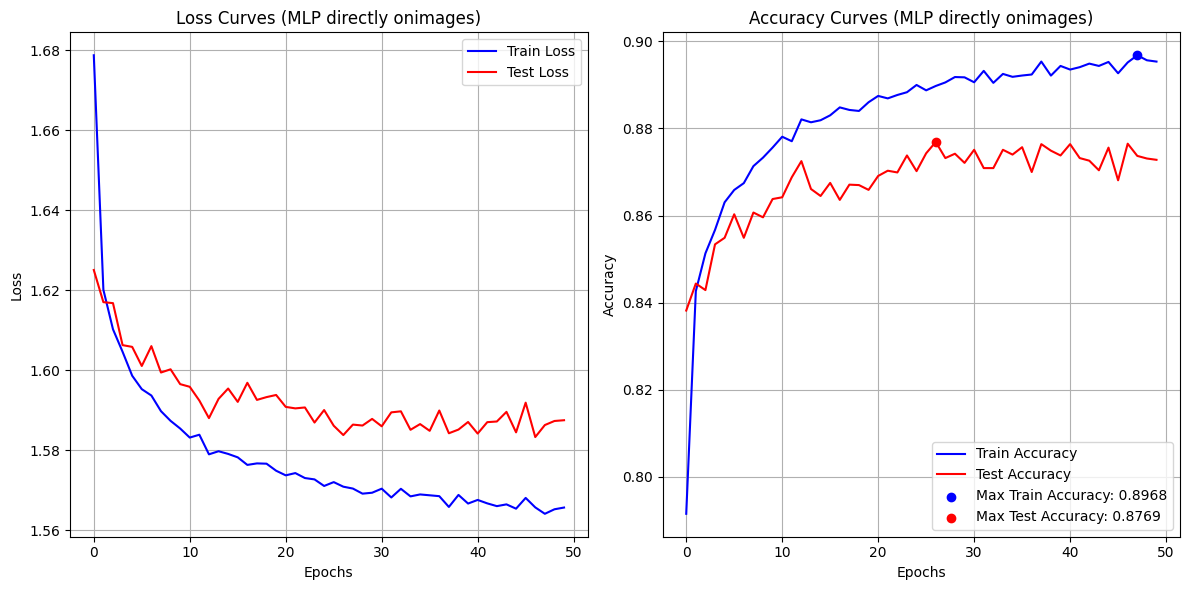

In [265]:
plot_accuracies_and_losses(train_losses, test_losses, train_accuracies, test_accuracies, "MLP directly onimages")

## CNN

60000 60000 10000
torch.Size([1, 28, 28]) torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


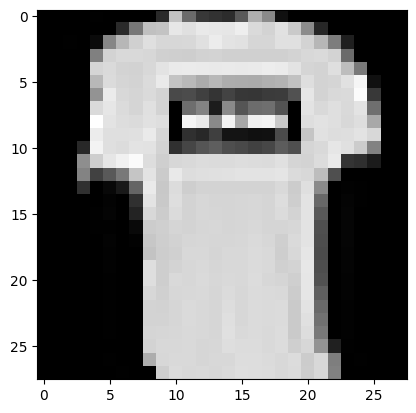

In [266]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
train_dataset_augmented = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform_augmented)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


print(len(train_dataset), len(train_dataset_augmented), len(test_dataset))
print(train_loader.dataset[0][0].shape, train_loader_augmented.dataset[0][0].shape, test_loader.dataset[0][0].shape)
plt.imshow(train_dataset_augmented[1][0].squeeze(), cmap='gray')

In [267]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(

            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1x28x28, Output: 32x28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 32x14x14
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 64x7x7
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Output: 128x7x7
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # Global Average Pooling
        self.global_pooling = nn.AdaptiveAvgPool2d(1)  # Output: 128x1x1
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                # Output: 128
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_pooling(x)
        x = self.fc_layers(x)
        return x
    
model = CNN(num_classes=len(np.unique(train_labels)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
num_epochs = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda


In [268]:
def train_cnn(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=True)
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()

            train_bar.set_postfix(loss=loss.item())

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Testing", leave=True)
            for X_batch, y_batch in test_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                test_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / len(test_loader.dataset))
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [269]:
# Train with unaugmented images
train_losses_no_aug, test_losses_no_aug, train_accuracies_no_aug, test_accuracies_no_aug = train_cnn(
    model, train_loader, test_loader, criterion, optimizer, num_epochs, device
)

Epoch 1/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 124.63it/s]


Epoch 1/30, Train Loss: 0.8504, Test Loss: 0.5484, Train Acc: 0.7124, Test Acc: 0.7985


Epoch 2/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 124.98it/s]


Epoch 2/30, Train Loss: 0.4704, Test Loss: 0.6056, Train Acc: 0.8339, Test Acc: 0.7759


Epoch 3/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 125.02it/s]


Epoch 3/30, Train Loss: 0.4009, Test Loss: 0.4549, Train Acc: 0.8597, Test Acc: 0.8340


Epoch 4/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 124.59it/s]


Epoch 4/30, Train Loss: 0.3671, Test Loss: 0.4136, Train Acc: 0.8711, Test Acc: 0.8550


Epoch 5/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 125.79it/s]


Epoch 5/30, Train Loss: 0.3423, Test Loss: 0.4367, Train Acc: 0.8802, Test Acc: 0.8422


Epoch 6/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 125.01it/s]


Epoch 6/30, Train Loss: 0.3194, Test Loss: 0.3461, Train Acc: 0.8882, Test Acc: 0.8765


Epoch 7/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 126.03it/s]


Epoch 7/30, Train Loss: 0.3065, Test Loss: 0.3641, Train Acc: 0.8927, Test Acc: 0.8713


Epoch 8/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 106.83it/s]


Epoch 8/30, Train Loss: 0.2934, Test Loss: 0.3732, Train Acc: 0.8972, Test Acc: 0.8675


Epoch 9/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.73it/s]


Epoch 9/30, Train Loss: 0.2824, Test Loss: 0.3284, Train Acc: 0.9015, Test Acc: 0.8798


Epoch 10/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 120.39it/s]


Epoch 10/30, Train Loss: 0.2703, Test Loss: 0.3818, Train Acc: 0.9068, Test Acc: 0.8629


Epoch 11/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 125.00it/s]


Epoch 11/30, Train Loss: 0.2623, Test Loss: 0.3004, Train Acc: 0.9076, Test Acc: 0.8965


Epoch 12/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 125.90it/s]


Epoch 12/30, Train Loss: 0.2547, Test Loss: 0.2737, Train Acc: 0.9106, Test Acc: 0.9016


Epoch 13/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 125.23it/s]


Epoch 13/30, Train Loss: 0.2470, Test Loss: 0.2722, Train Acc: 0.9121, Test Acc: 0.9022


Epoch 14/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 126.11it/s]


Epoch 14/30, Train Loss: 0.2390, Test Loss: 0.3746, Train Acc: 0.9153, Test Acc: 0.8657


Epoch 15/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 123.49it/s]


Epoch 15/30, Train Loss: 0.2340, Test Loss: 0.3399, Train Acc: 0.9169, Test Acc: 0.8869


Epoch 16/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 125.12it/s]


Epoch 16/30, Train Loss: 0.2264, Test Loss: 0.3432, Train Acc: 0.9206, Test Acc: 0.8796


Epoch 17/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 126.07it/s]


Epoch 17/30, Train Loss: 0.2208, Test Loss: 0.3747, Train Acc: 0.9212, Test Acc: 0.8706


Epoch 18/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 124.44it/s]


Epoch 18/30, Train Loss: 0.2159, Test Loss: 0.3284, Train Acc: 0.9225, Test Acc: 0.8852


Epoch 19/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 124.34it/s]


Epoch 19/30, Train Loss: 0.2100, Test Loss: 0.3111, Train Acc: 0.9253, Test Acc: 0.8938


Epoch 20/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 124.64it/s]


Epoch 20/30, Train Loss: 0.2039, Test Loss: 0.3545, Train Acc: 0.9275, Test Acc: 0.8780


Epoch 21/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 126.42it/s]


Epoch 21/30, Train Loss: 0.1980, Test Loss: 0.3269, Train Acc: 0.9294, Test Acc: 0.8885


Epoch 22/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 124.94it/s]


Epoch 22/30, Train Loss: 0.1933, Test Loss: 0.3399, Train Acc: 0.9324, Test Acc: 0.8833


Epoch 23/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 126.04it/s]


Epoch 23/30, Train Loss: 0.1908, Test Loss: 0.2640, Train Acc: 0.9332, Test Acc: 0.9076


Epoch 24/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 124.59it/s]


Epoch 24/30, Train Loss: 0.1874, Test Loss: 0.3455, Train Acc: 0.9344, Test Acc: 0.8803


Epoch 25/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 123.68it/s]


Epoch 25/30, Train Loss: 0.1805, Test Loss: 0.2906, Train Acc: 0.9360, Test Acc: 0.8989


Epoch 26/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 125.91it/s]


Epoch 26/30, Train Loss: 0.1780, Test Loss: 0.3065, Train Acc: 0.9367, Test Acc: 0.8950


Epoch 27/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 124.06it/s]


Epoch 27/30, Train Loss: 0.1723, Test Loss: 0.4506, Train Acc: 0.9381, Test Acc: 0.8556


Epoch 28/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 122.50it/s]


Epoch 28/30, Train Loss: 0.1674, Test Loss: 0.3066, Train Acc: 0.9404, Test Acc: 0.9002


Epoch 29/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 125.63it/s]


Epoch 29/30, Train Loss: 0.1645, Test Loss: 0.3063, Train Acc: 0.9417, Test Acc: 0.8971


Epoch 30/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 124.78it/s]

Epoch 30/30, Train Loss: 0.1596, Test Loss: 0.2645, Train Acc: 0.9437, Test Acc: 0.9090


In [270]:
# Train with augmented images

model_aug = CNN(num_classes=len(np.unique(train_labels)))
model_aug = model_aug.to(device)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)


train_losses_aug, test_losses_aug, train_accuracies_aug, test_accuracies_aug = train_cnn(
    model_aug, train_loader_augmented, test_loader, criterion, optimizer_aug, num_epochs, device
)

Epoch 1/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.06it/s]


Epoch 1/30, Train Loss: 0.4342, Test Loss: 0.3280, Train Acc: 0.8443, Test Acc: 0.8836


Epoch 2/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 88.61it/s]


Epoch 2/30, Train Loss: 0.3891, Test Loss: 0.3339, Train Acc: 0.8608, Test Acc: 0.8791


Epoch 3/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 119.90it/s]


Epoch 3/30, Train Loss: 0.3711, Test Loss: 0.3792, Train Acc: 0.8653, Test Acc: 0.8638


Epoch 4/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 121.13it/s]


Epoch 4/30, Train Loss: 0.3583, Test Loss: 0.2995, Train Acc: 0.8705, Test Acc: 0.8909


Epoch 5/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.26it/s]


Epoch 5/30, Train Loss: 0.3526, Test Loss: 0.3253, Train Acc: 0.8714, Test Acc: 0.8846


Epoch 6/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.37it/s]


Epoch 6/30, Train Loss: 0.3384, Test Loss: 0.2999, Train Acc: 0.8775, Test Acc: 0.8912


Epoch 7/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.84it/s]


Epoch 7/30, Train Loss: 0.3345, Test Loss: 0.3461, Train Acc: 0.8786, Test Acc: 0.8682


Epoch 8/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.61it/s]


Epoch 8/30, Train Loss: 0.3265, Test Loss: 0.3397, Train Acc: 0.8825, Test Acc: 0.8773


Epoch 9/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.14it/s]


Epoch 9/30, Train Loss: 0.3171, Test Loss: 0.2832, Train Acc: 0.8839, Test Acc: 0.9011


Epoch 10/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.41it/s]


Epoch 10/30, Train Loss: 0.3113, Test Loss: 0.2997, Train Acc: 0.8866, Test Acc: 0.8902


Epoch 11/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.51it/s]


Epoch 11/30, Train Loss: 0.3078, Test Loss: 0.3131, Train Acc: 0.8885, Test Acc: 0.8821


Epoch 12/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.55it/s]


Epoch 12/30, Train Loss: 0.3028, Test Loss: 0.2716, Train Acc: 0.8899, Test Acc: 0.9024


Epoch 13/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.26it/s]


Epoch 13/30, Train Loss: 0.2998, Test Loss: 0.2500, Train Acc: 0.8899, Test Acc: 0.9078


Epoch 14/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.62it/s]


Epoch 14/30, Train Loss: 0.2985, Test Loss: 0.2512, Train Acc: 0.8918, Test Acc: 0.9084


Epoch 15/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 88.09it/s]


Epoch 15/30, Train Loss: 0.2946, Test Loss: 0.2540, Train Acc: 0.8921, Test Acc: 0.9074


Epoch 16/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.94it/s]


Epoch 16/30, Train Loss: 0.2870, Test Loss: 0.2606, Train Acc: 0.8955, Test Acc: 0.9062


Epoch 17/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.27it/s]


Epoch 17/30, Train Loss: 0.2866, Test Loss: 0.2821, Train Acc: 0.8952, Test Acc: 0.8996


Epoch 18/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 86.29it/s]


Epoch 18/30, Train Loss: 0.2799, Test Loss: 0.2902, Train Acc: 0.8988, Test Acc: 0.8965


Epoch 19/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.59it/s]


Epoch 19/30, Train Loss: 0.2791, Test Loss: 0.2670, Train Acc: 0.8980, Test Acc: 0.9062


Epoch 20/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.32it/s]


Epoch 20/30, Train Loss: 0.2756, Test Loss: 0.2496, Train Acc: 0.9002, Test Acc: 0.9088


Epoch 21/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.53it/s]


Epoch 21/30, Train Loss: 0.2734, Test Loss: 0.2457, Train Acc: 0.8998, Test Acc: 0.9135


Epoch 22/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.09it/s]


Epoch 22/30, Train Loss: 0.2695, Test Loss: 0.2607, Train Acc: 0.9024, Test Acc: 0.9059


Epoch 23/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.16it/s]


Epoch 23/30, Train Loss: 0.2672, Test Loss: 0.2455, Train Acc: 0.9021, Test Acc: 0.9104


Epoch 24/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.99it/s]


Epoch 24/30, Train Loss: 0.2671, Test Loss: 0.2587, Train Acc: 0.9024, Test Acc: 0.9083


Epoch 25/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.18it/s]


Epoch 25/30, Train Loss: 0.2618, Test Loss: 0.2354, Train Acc: 0.9043, Test Acc: 0.9128


Epoch 26/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.55it/s]


Epoch 26/30, Train Loss: 0.2604, Test Loss: 0.2395, Train Acc: 0.9052, Test Acc: 0.9139


Epoch 27/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 86.49it/s]


Epoch 27/30, Train Loss: 0.2613, Test Loss: 0.2253, Train Acc: 0.9050, Test Acc: 0.9179


Epoch 28/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.29it/s]


Epoch 28/30, Train Loss: 0.2567, Test Loss: 0.2508, Train Acc: 0.9062, Test Acc: 0.9085


Epoch 29/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.37it/s]


Epoch 29/30, Train Loss: 0.2552, Test Loss: 0.2415, Train Acc: 0.9072, Test Acc: 0.9115


Epoch 30/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 87.21it/s]

Epoch 30/30, Train Loss: 0.2584, Test Loss: 0.2189, Train Acc: 0.9051, Test Acc: 0.9189


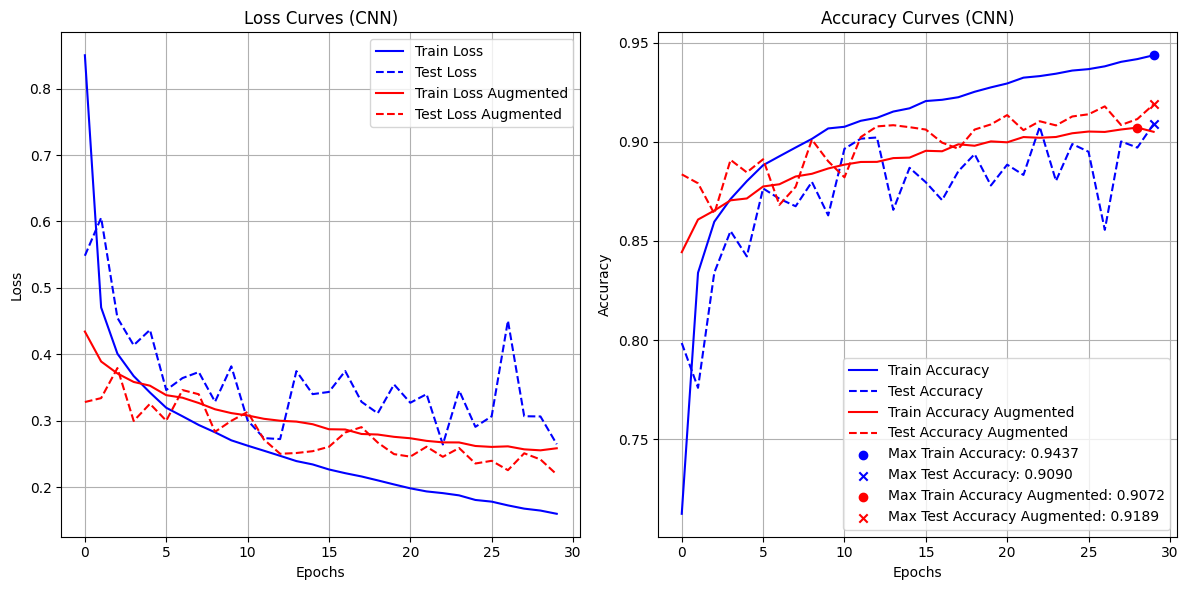

In [271]:
def plot_accuracies_and_losses_2(train_losses, test_losses, train_accuracies, test_accuracies,
                                 train_losses_aug, test_losses_aug, train_accuracies_aug, test_accuracies_aug, title):
    
    max_train_accuracy = max(train_accuracies)
    max_test_accuracy = max(test_accuracies)
    max_train_epoch = train_accuracies.index(max_train_accuracy)
    max_test_epoch = test_accuracies.index(max_test_accuracy)

    max_train_accuracy_aug = max(train_accuracies_aug)
    max_test_accuracy_aug = max(test_accuracies_aug)
    max_train_epoch_aug = train_accuracies_aug.index(max_train_accuracy_aug)
    max_test_epoch_aug = test_accuracies_aug.index(max_test_accuracy_aug)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)

    plt.plot(train_losses, label="Train Loss", color='b')
    plt.plot(test_losses, label="Test Loss", color='b', linestyle='--')
    plt.plot(train_losses_aug, label="Train Loss Augmented", color='r')
    plt.plot(test_losses_aug, label="Test Loss Augmented", color='r', linestyle='--')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves ({title})")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)

    plt.plot(train_accuracies, label="Train Accuracy", color='b')
    plt.plot(test_accuracies, label="Test Accuracy", color='b', linestyle='--')
    plt.plot(train_accuracies_aug, label="Train Accuracy Augmented", color='r')
    plt.plot(test_accuracies_aug, label="Test Accuracy Augmented", color='r', linestyle='--')

    plt.scatter(max_train_epoch, max_train_accuracy, color='blue', label=f"Max Train Accuracy: {max_train_accuracy:.4f}", zorder=5)
    plt.scatter(max_test_epoch, max_test_accuracy, color='blue', label=f"Max Test Accuracy: {max_test_accuracy:.4f}", zorder=5, marker='x')
    plt.scatter(max_train_epoch_aug, max_train_accuracy_aug, color='red', label=f"Max Train Accuracy Augmented: {max_train_accuracy_aug:.4f}", zorder=5)
    plt.scatter(max_test_epoch_aug, max_test_accuracy_aug, color='red', label=f"Max Test Accuracy Augmented: {max_test_accuracy_aug:.4f}", zorder=5, marker='x')

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curves ({title})")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


plot_accuracies_and_losses_2(train_losses_no_aug, test_losses_no_aug, train_accuracies_no_aug, test_accuracies_no_aug,
                                train_losses_aug, test_losses_aug, train_accuracies_aug, test_accuracies_aug, "CNN")

## Fine-tuning ResNet-18

In [272]:
train_transform_resnet = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616])
])

test_transform_resnet = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616])
])

train_dataset_resnet = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform_resnet)
test_dataset_resnet = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform_resnet)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=64, shuffle=True)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=64, shuffle=False)

In [273]:
model_resnet18 = resnet18_cifar10(pretrained=True)

num_features = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_features, len(np.unique(train_labels)))

model_resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, len(np.unique(train_labels)))
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet18 = model_resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(model_resnet18.parameters(), lr=0.0005, momentum=0.9)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=5, gamma=0.1)


c:\Users\Alex\Documents\GitHub\invatare-automata\tema2-image-classification\cifar10_models\resnet.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

In [274]:
def train_resnet(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=True)
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()

            train_bar.set_postfix(loss=loss.item())

            

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        scheduler.step()

        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Testing", leave=True)
            for X_batch, y_batch in test_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                test_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / len(test_loader.dataset))

        

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [275]:
num_epochs = 12
train_losses_resnet, test_losses_resnet, train_accuracies_resnet, test_accuracies_resnet = train_resnet(
    model_resnet18, train_loader_resnet, test_loader_resnet, criterion, optimizer_resnet, scheduler_resnet, num_epochs, device
)

Epoch 1/12 Testing: 100%|██████████| 157/157 [00:03<00:00, 40.20it/s]


Epoch 1/12, Train Loss: 1.3058, Test Loss: 0.4885, Train Acc: 0.7336, Test Acc: 0.8956


Epoch 2/12 Testing: 100%|██████████| 157/157 [00:03<00:00, 39.90it/s]


Epoch 2/12, Train Loss: 0.3918, Test Loss: 0.2913, Train Acc: 0.9051, Test Acc: 0.9017


Epoch 3/12 Testing: 100%|██████████| 157/157 [00:03<00:00, 40.25it/s]


Epoch 3/12, Train Loss: 0.2806, Test Loss: 0.2317, Train Acc: 0.9210, Test Acc: 0.9214


Epoch 4/12 Testing: 100%|██████████| 157/157 [00:03<00:00, 40.14it/s]


Epoch 4/12, Train Loss: 0.2321, Test Loss: 0.2394, Train Acc: 0.9324, Test Acc: 0.9188


Epoch 5/12 Testing: 100%|██████████| 157/157 [00:04<00:00, 39.23it/s]


Epoch 5/12, Train Loss: 0.1969, Test Loss: 0.2594, Train Acc: 0.9418, Test Acc: 0.9162


Epoch 6/12 Testing: 100%|██████████| 157/157 [00:04<00:00, 39.24it/s]


Epoch 6/12, Train Loss: 0.1337, Test Loss: 0.1898, Train Acc: 0.9633, Test Acc: 0.9388


Epoch 7/12 Testing: 100%|██████████| 157/157 [00:03<00:00, 40.08it/s]


Epoch 7/12, Train Loss: 0.1139, Test Loss: 0.1878, Train Acc: 0.9706, Test Acc: 0.9398


Epoch 8/12 Testing: 100%|██████████| 157/157 [00:03<00:00, 39.94it/s]


Epoch 8/12, Train Loss: 0.1003, Test Loss: 0.1906, Train Acc: 0.9753, Test Acc: 0.9417


Epoch 9/12 Testing: 100%|██████████| 157/157 [00:03<00:00, 39.90it/s]


Epoch 9/12, Train Loss: 0.0880, Test Loss: 0.2034, Train Acc: 0.9792, Test Acc: 0.9381


Epoch 10/12 Testing: 100%|██████████| 157/157 [00:03<00:00, 39.83it/s]


Epoch 10/12, Train Loss: 0.0784, Test Loss: 0.2035, Train Acc: 0.9821, Test Acc: 0.9410


Epoch 11/12 Testing: 100%|██████████| 157/157 [00:03<00:00, 40.08it/s]


Epoch 11/12, Train Loss: 0.0663, Test Loss: 0.2035, Train Acc: 0.9871, Test Acc: 0.9404


Epoch 12/12 Testing: 100%|██████████| 157/157 [00:03<00:00, 39.85it/s]

Epoch 12/12, Train Loss: 0.0656, Test Loss: 0.2042, Train Acc: 0.9875, Test Acc: 0.9413


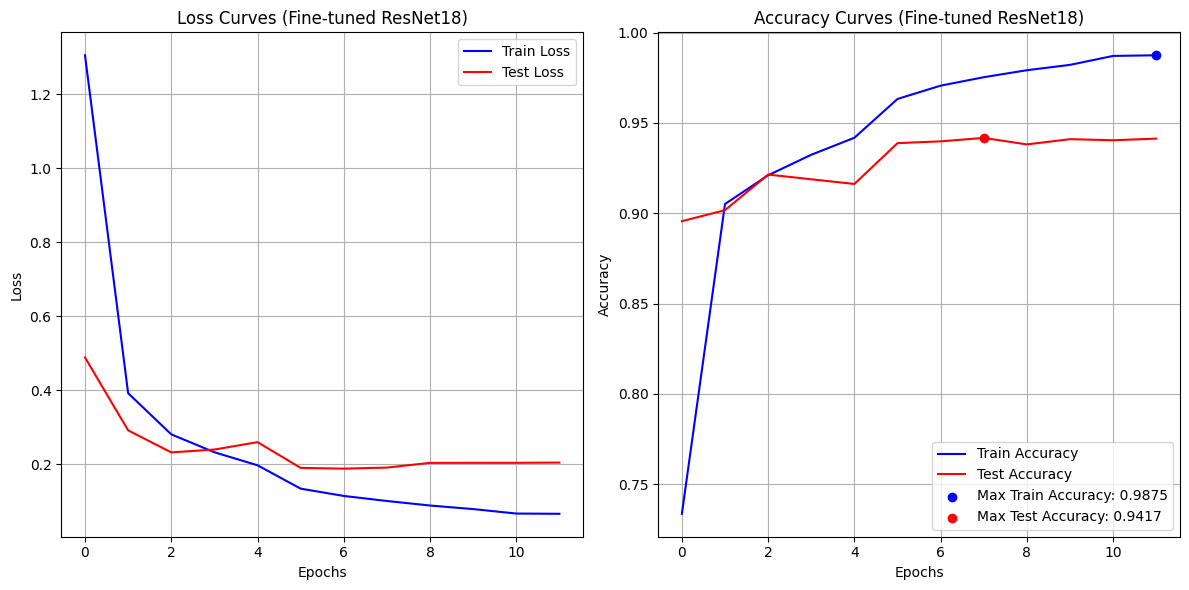

In [276]:
plot_accuracies_and_losses(train_losses_resnet, test_losses_resnet, train_accuracies_resnet, test_accuracies_resnet, "Fine-tuned ResNet18")